# Generación de piezas musicales monofónicas con RNN-LSTM

In [ ]:
!pip install pypianoroll

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K 
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import gc
import pickle
from sklearn.model_selection import train_test_split
import pypianoroll as pr
import matplotlib.pyplot as plt

In [ ]:
ENV = 'colab'
if(ENV == 'colab'):
    BASE_PATH = '/content/drive/MyDrive/uni/TFG2023/generative-music/'
    from google.colab import drive
    drive.mount('/content/drive')
    
elif(ENV == 'local'):
    BASE_PATH = './'
else:
    raise Exception()

In [ ]:
DATASET = 'sample'
DATA_PATH=os.path.join(BASE_PATH, 'data')
DATASET_PATH = os.path.join(DATA_PATH, DATASET)

STORE_PATH=os.path.join(BASE_PATH,'generated')

RANDOM_SEED=616

## Single-input naïve LSTM
La primera aproximación a la generación musical la haremos mediante un modelo de redes neuronales recurrentes, que suelen funcionar bien a la hora de 'aprender' secuencias temporales, como la música, gracias a sus conexiones recurrentes, que funcionan a modo de 'memoria a largo plazo'. 
El modelo es una red neuronal con dos capas de neuronas LSTM, a la que entrenaremos con los datos codificados de nota (o notas) y duración, para que aprenda a mapear una entrada [notas previas, duraciones previas] a una salida [nota siguiente, duración siguiente]

In [ ]:
class RNNDatasetEncoder:
    
    def __init__(self, path, seq_len=32, delimiter='/'):
        self.path = path
        self.parsed_files = self.load()
        self.seq_len = seq_len
        self.delimiter = delimiter
    
    def load(self):
        
        # Get song data from data_path and parse it as a pypianoroll object
        songs = {}

        for path,subdir,files in os.walk(self.path):
            for file in files:
                if (file[-3:] == 'mid'):
                    try:
                        song = pr.read(os.path.join(path,file))
                        songs[file[:-4]] = song
                    except:
                        print(f'Parsing file {file} failed. Skipping.')
                        continue
        return songs
        
    def encode(self):
        # Load files
        titles, files = list(self.parsed_files.keys()), list(self.parsed_files.values())

        pitches = []
        durations = []

        for i,file in enumerate(files):
            print(f'Processing song {titles[i]}')
            # binarize pianorolls & blend all tracks
            binarized = file.binarize()
            blended = binarized.blend()

            # Clean short songs
            if(blended.shape[0] < 10):
                print(f'Skipping song {titles[i]}')
                continue

            song_pitches, song_durations = self.encode_song(blended)
            pitches=pitches + [self.delimiter] * self.seq_len
            pitches=pitches + song_pitches
            durations=durations + [0] * self.seq_len
            durations=durations + song_durations


        print(f'Parsed {len(files)} songs.')

        self.pitch_vocab_size = len(list(set(pitches)))
        self.pitch_encodings = {v:i for i,v in enumerate(list(set(pitches)))}
        self.duration_vocab_size = len(list(set(durations)))
        self.duration_encodings = {v:i for i,v in enumerate(list(set(durations)))}

        self.pitches = pitches
        self.durations = durations
    
    def encode_song(self, song):
        notes = []
        encoded_durations = []
        for ts in song:
            hot_notes = np.where(ts == 1)
            symbol = '.'.join([str(e) for e in hot_notes[0]])

            notes.append(symbol)
        encoded_notes, encoded_durations = self.get_notes_durations(notes)
        return encoded_notes, encoded_durations
    
    def get_notes_durations(self, seq):
        notes = []
        durations = []
        ts = 1
        for i,e in enumerate(seq[:-1]):
            if(seq[i+1] == e):
                ts+=1
            else:
                notes.append(e)
                durations.append(ts)
                ts=1
        notes.append(seq[-1])
        durations.append(ts)
        return notes, durations

In [ ]:
class RNNSequenceGenerator:
    def __init__(self, generator, seq_len = 32):
        self.pitches = generator.pitches
        self.durations = generator.durations
        self.pitch_encodings = generator.pitch_encodings
        self.pitch_vocab_size = generator.pitch_vocab_size
        self.duration_encodings = generator.duration_encodings
        self.duration_vocab_size = generator.duration_vocab_size
        self.seq_len = seq_len
        
    def generate_sequences(self, validation_split=0.15):
        inputs = []
        pitch_outputs = []
        duration_outputs = []

        for i in range(len(self.pitches)-self.seq_len):
            pitch_sequence_in = self.pitches[i:i + self.seq_len]
            duration_sequence_in = self.durations[i:i + self.seq_len]
            
            pitch_sequence_out = self.pitches[i + self.seq_len]
            duration_sequence_out = self.durations[i + self.seq_len]

            pitch_sequence_in=[self.pitch_encodings[char] for char in pitch_sequence_in]
            duration_sequence_in=[self.duration_encodings[char] for char in duration_sequence_in]
            
            pitch_sequence_out=self.pitch_encodings[pitch_sequence_out]
            duration_sequence_out=self.duration_encodings[duration_sequence_out]
            
            sequence_in = [list(a) for a in zip(pitch_sequence_in, duration_sequence_in)]
            
            pitch_outputs.append(pitch_sequence_out)
            duration_outputs.append(duration_sequence_out)
            
            inputs.append(sequence_in)

        inputs = np.reshape(inputs, (len(inputs), self.seq_len, 2))
        
        pitch_outputs = to_categorical(pitch_outputs,self.pitch_vocab_size)
        duration_outputs = to_categorical(duration_outputs,self.duration_vocab_size)
        outputs = [pitch_outputs, duration_outputs]
        
        print(f'Input shape: {inputs[0].shape}')
        print(f'Output shape: {outputs[0].shape}')
        
        X_train, X_valid, y_p_train, y_p_valid, y_d_train, y_d_valid = train_test_split(inputs, pitch_outputs,duration_outputs, test_size=validation_split, random_state=RANDOM_SEED)
        
        return X_train, X_valid, y_p_train, y_p_valid, y_d_train, y_d_valid

In [ ]:
class RNNBase:
        
    def __init__(self, num_units, loss, lr, seq_len):

        # create model architecture
        self.name = 'base_lstm'
        
        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))
        
        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)
        
        i = keras.layers.Input(shape=(seq_len,2))

        x = keras.layers.LSTM(num_units[0],return_sequences=True)(i)
        #x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.LSTM(num_units[1])(x)
        c = keras.layers.Dropout(0.2)(x)

        note_output = keras.layers.Dense(num_units[2], activation='softmax', name='pitch')(c)
        duration_output = keras.layers.Dense(num_units[3], activation='softmax', name='duration')(c)

        model = keras.Model(i, [note_output,duration_output], name=self.name)
        att_model = None
        
        # compile model
        optimizer = keras.optimizers.Adam(learning_rate=lr) # keras.optimizers.RMSprop(lr = lr)
        model.compile(loss=[loss,loss], optimizer=optimizer, metrics=['accuracy'])

        self.model = model
        self.att_model = att_model
        
        self.get_model_summary()
    
    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=100, batch_size=32):
    
        weights_folder = self.weights_folder
        
        checkpoint1 = ModelCheckpoint(
            os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        checkpoint2 = ModelCheckpoint(
            os.path.join(weights_folder, "weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [
            checkpoint1
            , checkpoint2
            , early_stopping
         ]

        self.model.save_weights(os.path.join(weights_folder, "weights.h5"))
        history = self.model.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )
        
        self.model.save(os.path.join(weights_folder, "weights.h5"))
        
        return history
        
    def get_model_summary(self):
        self.model.summary()
        
    def plot_model_graph(self):
        return plot_model(self.model)
    
    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['pitch_accuracy'])
        plt.plot(history.history['duration_accuracy'])
        plt.plot(history.history['val_pitch_accuracy'])
        plt.plot(history.history['val_duration_accuracy'])
        
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train (pitch)','Train (duration)', 'Validation (pitch)', 'Validation (duration)'])
        plt.show()

In [ ]:
class RNNSampleGenerator:
    def __init__(self, model, encoder, store_path=STORE_PATH):
        self.model = model.model
        self.encoder = encoder
        self.n_sample = 0
        self.store_path = store_path
        
    def generate(self, seed, sample_length, temperature=0.):
                
        note_stream, duration_stream = seed
        prob_heatmap = []
        
        # create seed with start symbol
        notes_seed, durations_seed = seed
        
        notes_seed = [self.encoder.delimiter] * self.encoder.seq_len + notes_seed
        notes_seed = [self.encoder.pitch_encodings[symbol] for symbol in notes_seed]

        durations_seed = [0] * self.encoder.seq_len + durations_seed
        durations_seed = [self.encoder.duration_encodings[symbol] for symbol in durations_seed]
        
        
        for _ in range(sample_length):
            
            # limit seed to max_seq_len
            notes_seed = notes_seed[-self.encoder.seq_len:]
            durations_seed = durations_seed[-self.encoder.seq_len :]
            
            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            # network_input = [np.reshape(notes_seed,(1,64)),np.reshape(durations_seed,(1,self.seq_len))]
            network_input = [list(a) for a in zip(notes_seed,durations_seed)]
            network_input = np.reshape(network_input,(1,self.encoder.seq_len,2))
            
            
            # make a prediction
            note_prob_dist, duration_prob_dist = self.model.predict(network_input,verbose=0)
            # [0.1, 0.2, 0.1, 0.6] example -> softmax adds to 1
            prob_heatmap.append(note_prob_dist[0])
            
            note_output = self._sample_with_temperature(note_prob_dist[0], temperature)
            duration_output = self._sample_with_temperature(duration_prob_dist[0], temperature)
            
            # update seed
            notes_seed.append(note_output)
            durations_seed.append(duration_output)
            
            # map int to encoding
            note_symbol = [k for k, v in self.encoder.pitch_encodings.items() if v == note_output][0]
            duration_symbol = [k for k, v in self.encoder.duration_encodings.items() if v == duration_output][0]
            
            # check end of melody
            if (note_symbol == self.encoder.delimiter):
                break
            
            # update melody
            note_stream.append(note_symbol)
            duration_stream.append(duration_symbol)
            
        self.generated_sequence = (note_stream, duration_stream)
        self.n_sample=self.n_sample+1
        self.prob_heatmap = prob_heatmap
        
        notes_seed = np.array(notes_seed)
        sampled_heatmap = np.zeros((notes_seed.size, notes_seed.max() + 1))
        sampled_heatmap[np.arange(notes_seed.size), notes_seed] = 1
        
        self.sampled_heatmap = sampled_heatmap
        
        print(f'Generated sample n.{self.n_sample}')
    
    def gen2midi(self):

        filename = f'{DATASET}-{self.model.name}_n_{self.n_sample}.mid'

        notes, durations = self.generated_sequence
        extended_song = self.unpack(notes,durations)

        pianoroll = self.encoding2pianoroll(extended_song)
        self.pianoroll = pianoroll

        bt = pr.BinaryTrack(name='track1', pianoroll=pianoroll)
        multitrack = pr.Multitrack(name='song1',tracks=[bt])
        
        self.plot_sample(multitrack)

        pr.write(f'{self.store_path}/{filename}', multitrack)
        print(f'Saved with name {filename}.')
        
    def unpack(self, notes, durations):
        timesteps = np.array([])
        for n,d in zip(notes,durations):
            timesteps = np.concatenate((timesteps, np.repeat(n,d)))
        return timesteps
    
    def encoding2pianoroll(self, extended_sample):
        ones_in = []
        pianoroll = np.zeros((extended_sample.shape[0],128),dtype='uint8')
        for i,n in enumerate(extended_sample):
            if(n==''):
                continue
            ones_in_ts = np.array([[i, int(n_i)] for n_i in n.split('.')])
            ones_in.append(ones_in_ts)
        ones_in = np.vstack(ones_in)
        rows = ones_in[:,0]
        cols = ones_in[:,1]
        pianoroll[rows,cols] = 1
        return pianoroll
    
    def plot_sample(self, midi):
        midi.plot()
        
    def plot_probs_heatmap(self):
        fig, ax = plt.subplots(figsize=(15,15))
        ax.set_yticks([int(j) for j in range(0, self.encoder.pitch_vocab_size)])

        heatmap = np.transpose(self.prob_heatmap)
        plt.imshow(heatmap, origin="lower", cmap='plasma')
        
    def plot_sample_heatmap(self):
        fig, ax = plt.subplots(figsize=(15,15))
        ax.set_yticks([int(j) for j in range(0, self.encoder.pitch_vocab_size)])

        heatmap = np.transpose(self.sampled_heatmap)
        plt.imshow(heatmap, origin="lower", cmap='plasma')
    
    def _sample_with_temperature(self, distribution, temperature):
        # temperature -> inf then acts like random sampling
        # temperature -> 0 then the highest prob wins
        # temperature -> 1 
        # how explorative we want the network to be

        predictions = np.log(distribution) / temperature
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(distribution)) # [0, 1, 2 ,3]
        index = np.random.choice(choices, p=distribution) # sample from probability distribution
            
        return index

In [ ]:
SEQ_LEN = 32
NUM_UNITS = [256,256]
LOSS = 'categorical_crossentropy'
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 64

# Dataset encoder
denc = RNNDatasetEncoder(DATASET_PATH, seq_len=SEQ_LEN)
denc.encode()

# Dataset sequence generator
seq_generator = RNNSequenceGenerator(denc, seq_len=SEQ_LEN)
X_train, X_valid, y_p_train, y_p_valid, y_d_train, y_d_valid = seq_generator.generate_sequences(validation_split=0.15)

y_train = [y_p_train, y_d_train]
y_valid = [y_p_valid, y_d_valid]

# Compile model
units_per_layer = NUM_UNITS + [denc.pitch_vocab_size, denc.duration_vocab_size]
rnn = RNNBase(units_per_layer, LOSS, LR, seq_len=SEQ_LEN)


Processing song aver2
Processing song gen
Parsed 2 songs.
Input shape: (32, 2)
Output shape: (132, 11)


2023-05-11 14:02:23.738195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 14:02:23.739750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 14:02:23.741067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "base_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 32, 2)]      0           []                               
                                                                                                  
 lstm_38 (LSTM)                 (None, 32, 256)      265216      ['input_17[0][0]']               
                                                                                                  
 lstm_39 (LSTM)                 (None, 256)          525312      ['lstm_38[0][0]']                
                                                                                                  
 dropout_16 (Dropout)           (None, 256)          0           ['lstm_39[0][0]']                
                                                                                          

2023-05-11 14:02:23.982142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 14:02:23.983642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 14:02:23.984819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
rnn.plot_model_graph()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
train_hist = rnn.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10


2023-05-11 14:02:26.593059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 14:02:26.595553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 14:02:26.596785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - ETA: 0s - loss: 4.0414 - pitch_loss: 2.2989 - duration_loss: 1.7424 - pitch_accuracy: 0.2232 - duration_accuracy: 0.1964

2023-05-11 14:02:30.397689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 14:02:30.399376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 14:02:30.400749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 5s 1s/step - loss: 4.0414 - pitch_loss: 2.2989 - duration_loss: 1.7424 - pitch_accuracy: 0.2232 - duration_accuracy: 0.1964 - val_loss: 3.1733 - val_pitch_loss: 1.7819 - val_duration_loss: 1.3915 - val_pitch_accuracy: 0.6000 - val_duration_accuracy: 0.6000
Epoch 2/10
2/2 [==============================] - 0s 240ms/step - loss: 3.3573 - pitch_loss: 1.9453 - duration_loss: 1.4120 - pitch_accuracy: 0.3929 - duration_accuracy: 0.4018 - val_loss: 2.8394 - val_pitch_loss: 1.4974 - val_duration_loss: 1.3419 - val_pitch_accuracy: 0.6000 - val_duration_accuracy: 0.3000
Epoch 3/10
2/2 [==============================] - 0s 232ms/step - loss: 3.0919 - pitch_loss: 1.7715 - duration_loss: 1.3203 - pitch_accuracy: 0.4107 - duration_accuracy: 0.4018 - val_loss: 2.6867 - val_pitch_loss: 1.3710 - val_duration_loss: 1.3157 - val_pitch_accuracy: 0.6000 - val_duration_accuracy: 0.3500
Epoch 4/10
2/2 [==============================] - 0s 259ms/step - loss: 2.9320 - pit

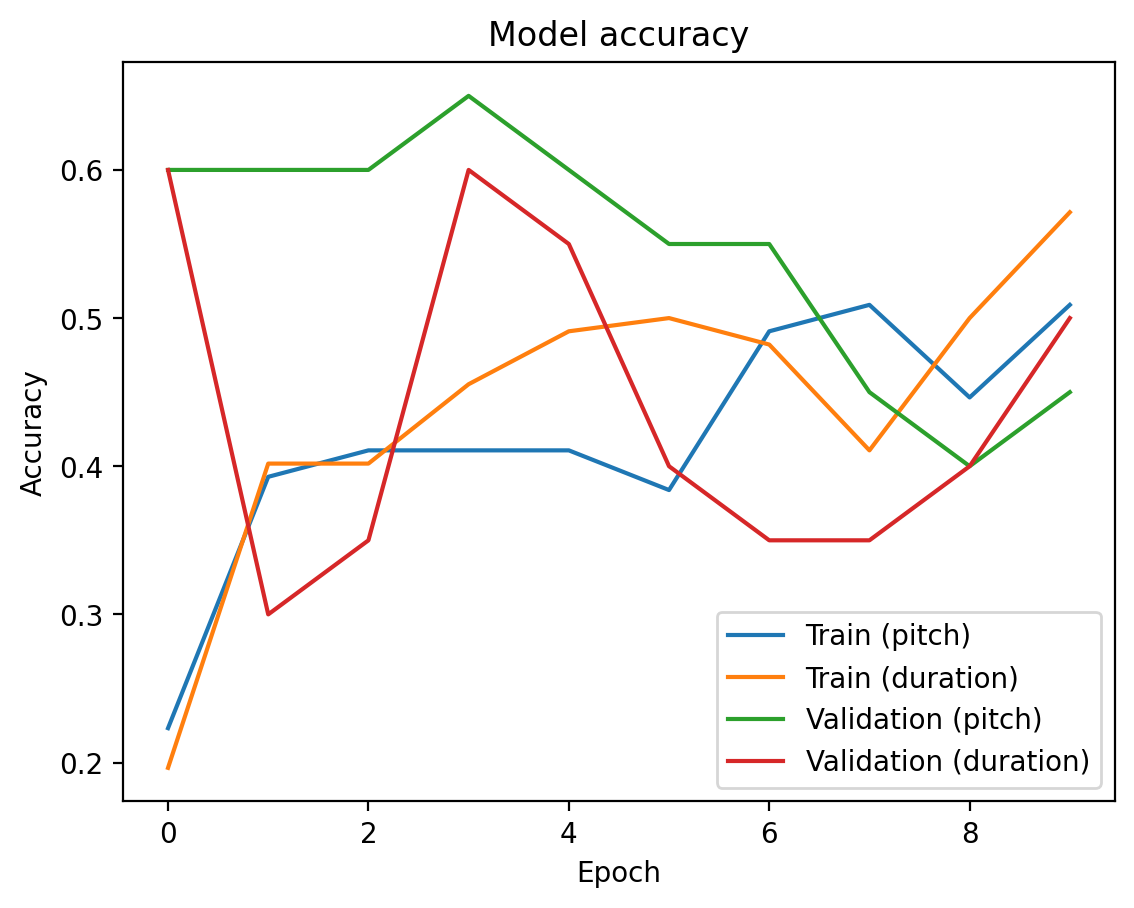

In [ ]:
rnn.plot_loss(train_hist)

In [ ]:
sample_generator = RNNSampleGenerator(rnn, encoder=denc)

Generated sample n.2
Saved with name sample-base_lstm_n_2.mid.


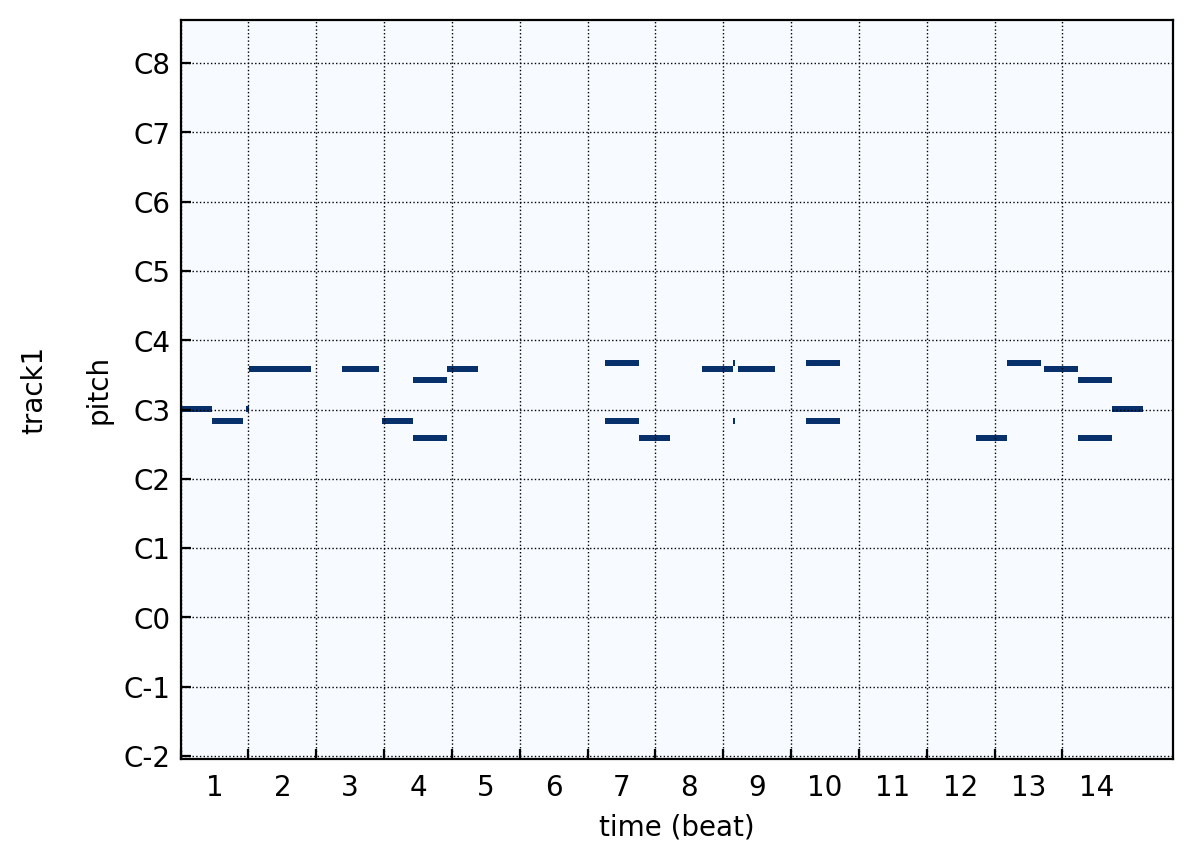

In [ ]:
sample_generator.generate(([],[]),sample_length=150,temperature=0.4)
sample_generator.gen2midi()

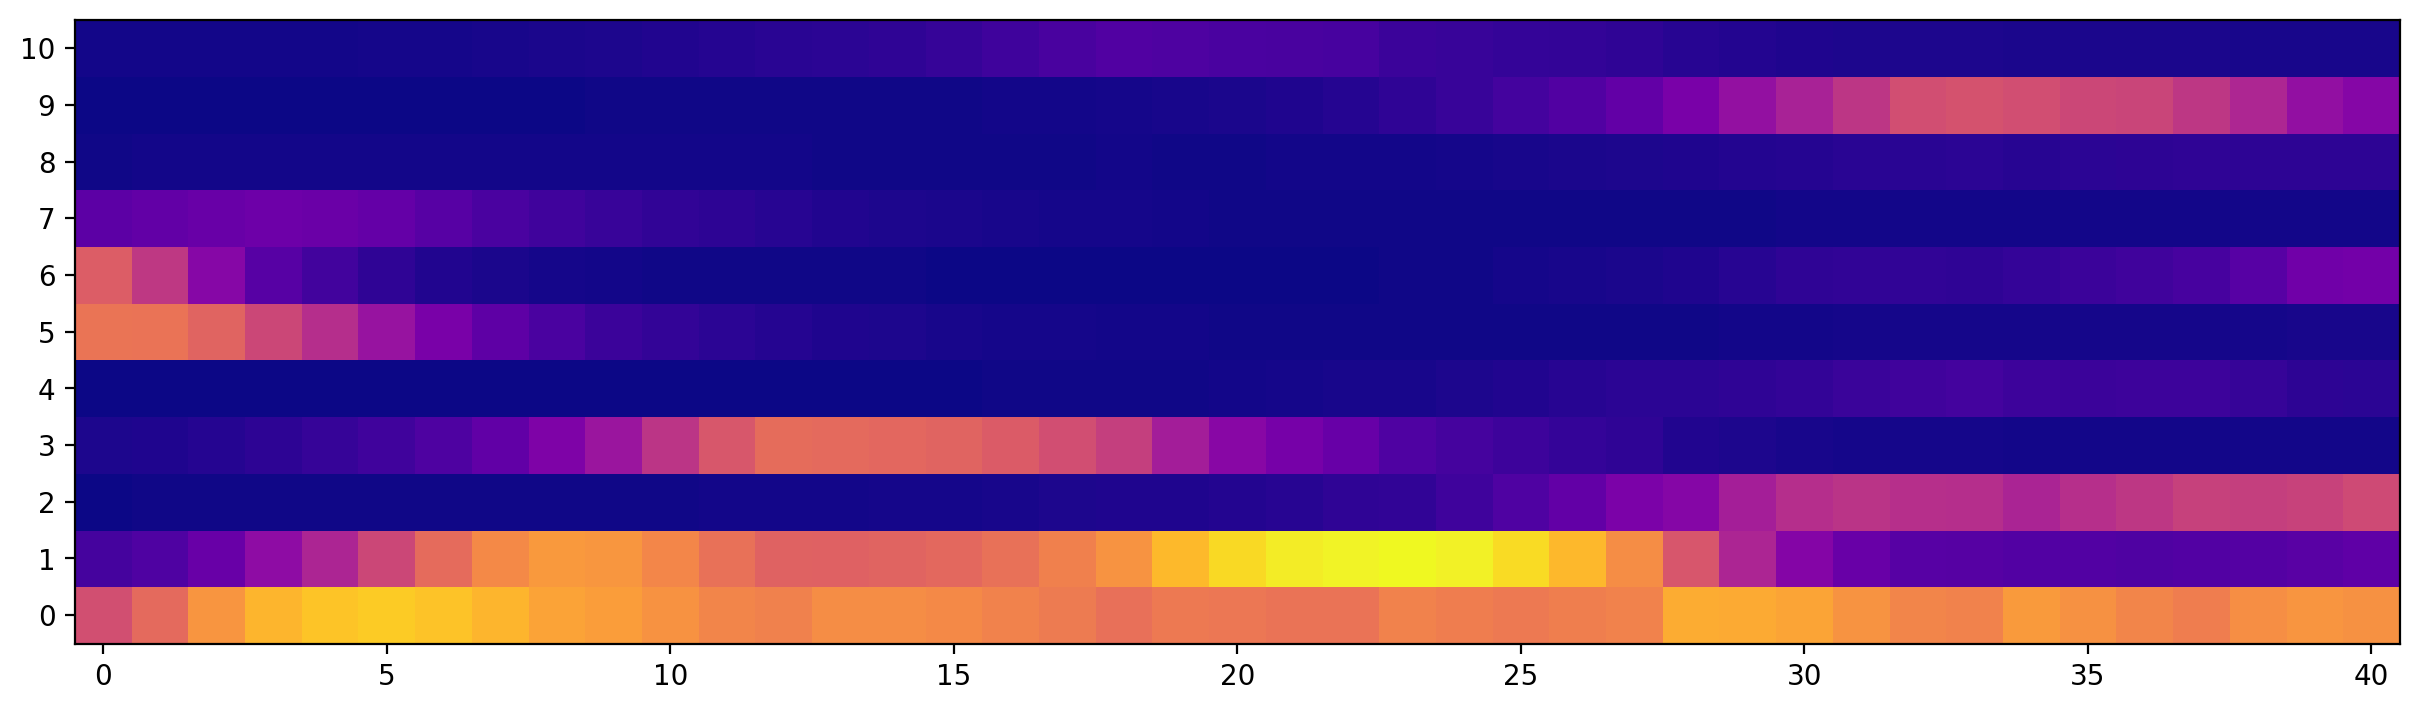

In [ ]:
sample_generator.plot_probs_heatmap()

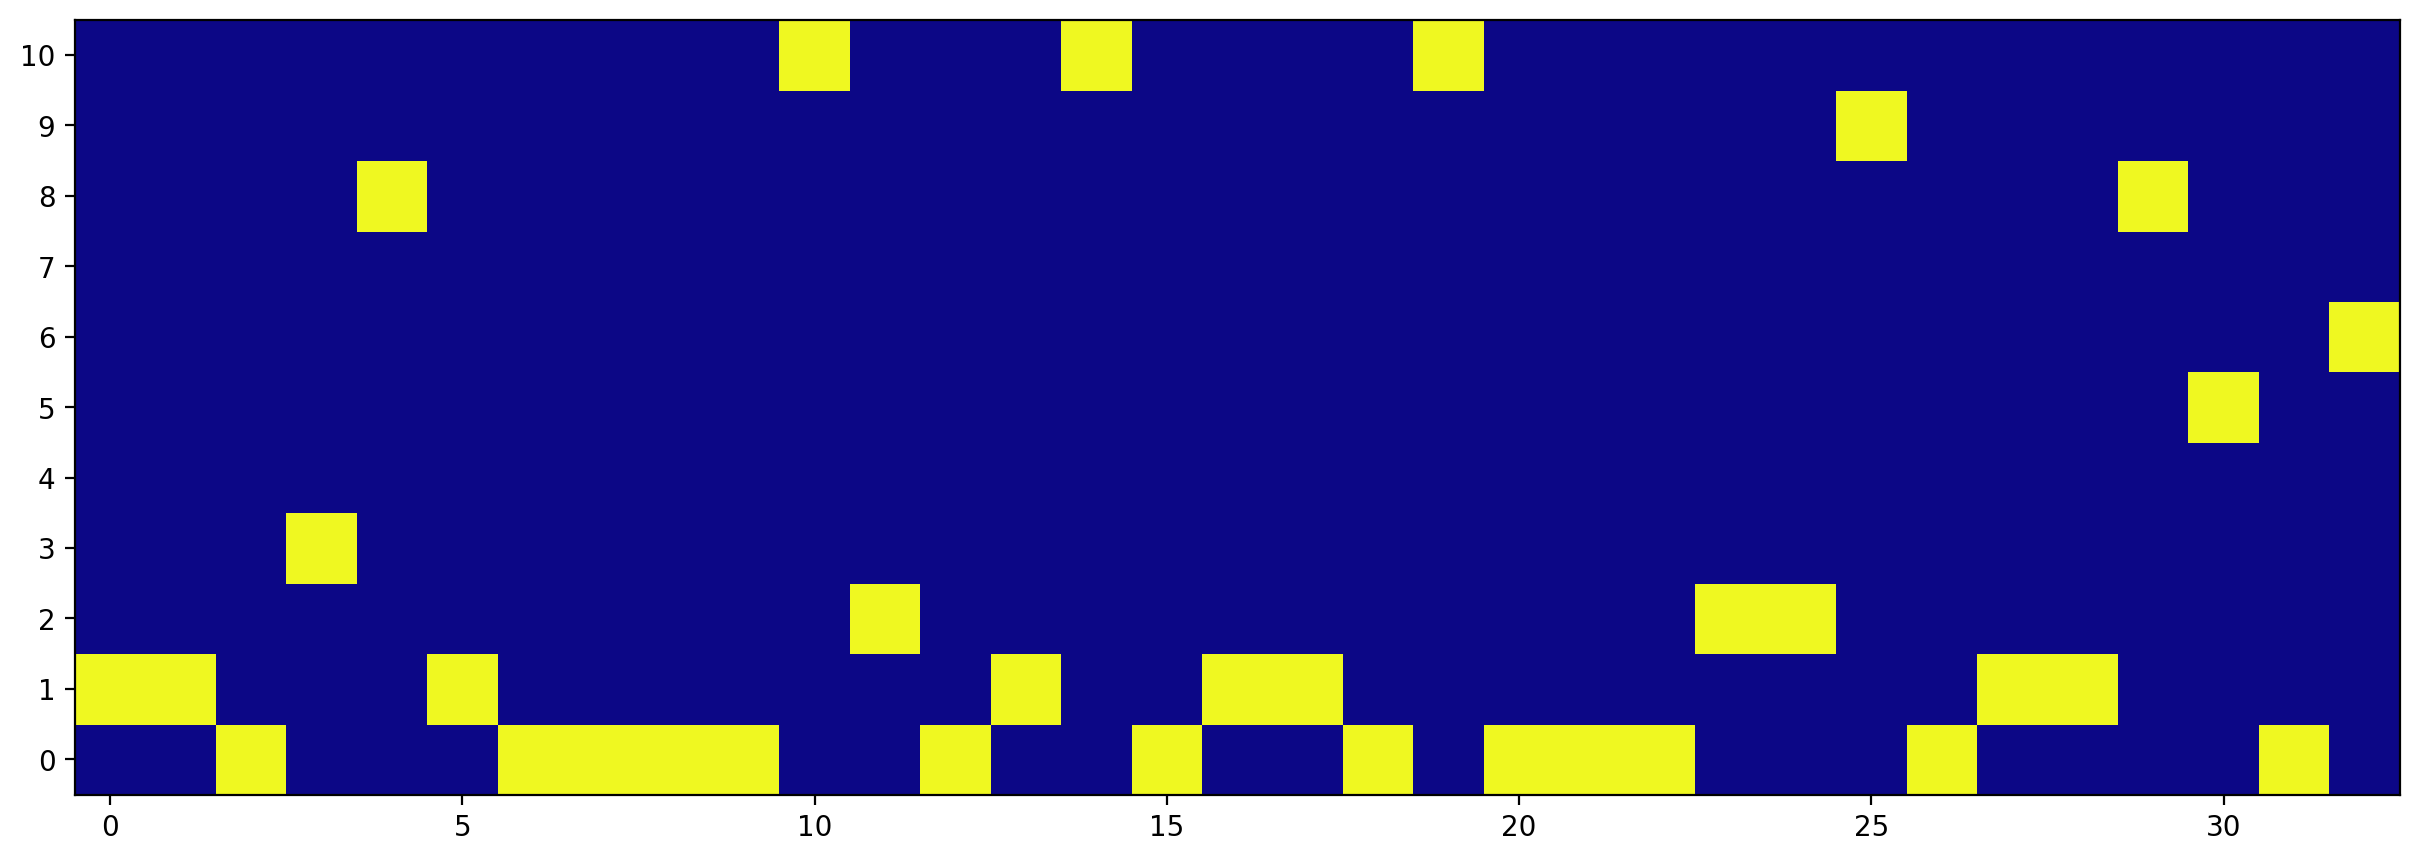

In [ ]:
sample_generator.plot_sample_heatmap()

## Single-input LSTM with attention mechanism

In [ ]:
class RNNAttention:
        
    def __init__(self, num_units, loss, lr, seq_len=32):

        # create model architecture
        self.name = 'lstm_attention'
        
        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))
        
        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)

        i = keras.layers.Input(shape=(seq_len,2))

        x = keras.layers.LSTM(num_units[0],return_sequences=True)(i)
        #x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.LSTM(num_units[1])(x)
        c = keras.layers.Dropout(0.2)(x)

        # ATTENTION MECHANISM
        e = keras.layers.Dense(1, activation='tanh')(x)
        e = keras.layers.Reshape([-1])(e)
        alpha = keras.layers.Activation('softmax')(e)

        alpha_repeated = keras.layers.Permute([2,1])(keras.layers.RepeatVector(num_units[0])(alpha))

        c = keras.layers.Multiply()([x, alpha_repeated])
        c = keras.layers.Lambda(lambda xi: K.sum(xi,axis=1), output_shape=(num_units[0],))(c)

        note_output = keras.layers.Dense(num_units[2], activation='softmax', name='pitch')(c)
        duration_output = keras.layers.Dense(num_units[3], activation='softmax', name='duration')(c)

        model = keras.Model(i, [note_output,duration_output], name=self.name)
        att_model = keras.Model(i, alpha, name=f'{self.name}_model')
        
        # compile model
        optimizer = keras.optimizers.Adam(learning_rate=lr) # keras.optimizers.RMSprop(lr = lr)
        model.compile(loss=[loss,loss], optimizer=optimizer, metrics=['accuracy'])

        self.model = model
        self.att_model = att_model
        
        self.get_model_summary()
    
    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=100, batch_size=32):
        weights_folder = self.weights_folder
        
        checkpoint1 = ModelCheckpoint(
            os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        checkpoint2 = ModelCheckpoint(
            os.path.join(weights_folder, "weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [
            checkpoint1
            , checkpoint2
            , early_stopping
         ]

        self.model.save_weights(os.path.join(weights_folder, "weights.h5"))
        history = self.model.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )
        
        self.model.save(os.path.join(weights_folder, "weights.h5"))
        
        return history
        
    def get_model_summary(self):
        self.model.summary()
        
    def plot_model_graph(self):
        return plot_model(self.model)
    
    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['pitch_accuracy'])
        plt.plot(history.history['duration_accuracy'])
        plt.plot(history.history['val_pitch_accuracy'])
        plt.plot(history.history['val_duration_accuracy'])
        
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train (pitch)','Train (duration)', 'Validation (pitch)', 'Validation (duration)'])
        plt.show()

In [ ]:
SEQ_LEN = 32
NUM_UNITS = [256,256]
LOSS = 'categorical_crossentropy'
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 64

# Dataset encoder
denc = RNNDatasetEncoder(DATASET_PATH, seq_len=SEQ_LEN)
denc.encode()

# Dataset sequence generator
seq_generator = RNNSequenceGenerator(denc, seq_len=SEQ_LEN)
X_train, X_valid, y_p_train, y_p_valid, y_d_train, y_d_valid = seq_generator.generate_sequences(validation_split=0.15)

y_train = [y_p_train, y_d_train]
y_valid = [y_p_valid, y_d_valid]

# Compile model
units_per_layer = NUM_UNITS + [denc.pitch_vocab_size, denc.duration_vocab_size]
rnn_attention = RNNAttention(units_per_layer, LOSS, LR, seq_len=SEQ_LEN)


Processing song chpn_op10_e05
Processing song chpn_op10_e12
Processing song chpn_op10_e01
Processing song chpn_op7_1
Processing song chpn_op7_2
Processing song chp_op18
Processing song chpn_op23
Processing song chpn_op25_e2
Processing song chpn_op25_e3
Processing song chpn_op25_e4
Processing song chpn_op25_e11
Processing song chpn_op25_e12
Processing song chpn_op27_1
Processing song chpn_op27_2
Processing song chpn-p1
Processing song chpn-p2
Processing song chpn-p3
Processing song chpn-p4
Processing song chpn-p5
Processing song chpn-p6
Processing song chpn-p7
Processing song chpn-p8
Processing song chpn-p10
Processing song chpn-p11
Processing song chpn-p12
Processing song chpn-p13
Processing song chpn-p14
Processing song chpn-p15
Processing song chpn-p16
Processing song chpn-p17
Processing song chpn-p18
Processing song chpn-p19
Processing song chpn-p20
Processing song chpn-p21
Processing song chpn-p22
Processing song chpn-p23
Processing song chpn-p24
Processing song chp_op31
Processing

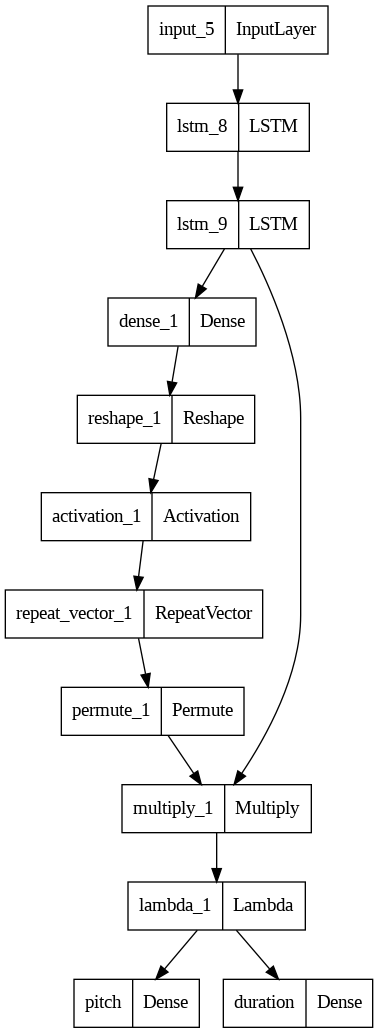

In [ ]:
rnn_attention.plot_model_graph()

In [ ]:
train_hist_att = rnn_attention.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/200
923/923 [==============================] - 23s 19ms/step - loss: 9.6069 - pitch_loss: 7.4338 - duration_loss: 2.1731 - pitch_accuracy: 0.1554 - duration_accuracy: 0.3713 - val_loss: 9.3677 - val_pitch_loss: 7.2663 - val_duration_loss: 2.1014 - val_pitch_accuracy: 0.1608 - val_duration_accuracy: 0.3857
Epoch 2/200
923/923 [==============================] - 16s 18ms/step - loss: 8.8204 - pitch_loss: 6.7784 - duration_loss: 2.0419 - pitch_accuracy: 0.1628 - duration_accuracy: 0.3876 - val_loss: 9.0669 - val_pitch_loss: 7.1444 - val_duration_loss: 1.9225 - val_pitch_accuracy: 0.1628 - val_duration_accuracy: 0.3998
Epoch 3/200
923/923 [==============================] - 15s 16ms/step - loss: 8.3326 - pitch_loss: 6.4091 - duration_loss: 1.9235 - pitch_accuracy: 0.1650 - duration_accuracy: 0.4051 - val_loss: 8.8587 - val_pitch_loss: 7.0125 - val_duration_loss: 1.8461 - val_pitch_accuracy: 0.1655 - val_duration_accuracy: 0.4242
Epoch 4/200
923/923 [==============================] - 

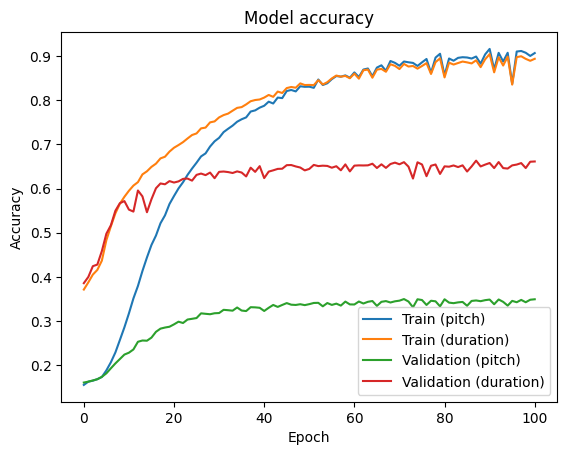

In [ ]:
rnn_attention.plot_loss(train_hist_att)

In [ ]:
sample_generator = RNNSampleGenerator(rnn_attention, encoder=denc)

<ipython-input-8-8648e35fcd1b>:108: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(distribution) / temperature


Generated sample n.1
Saved with name chopin-lstm_attention_n_1.mid.


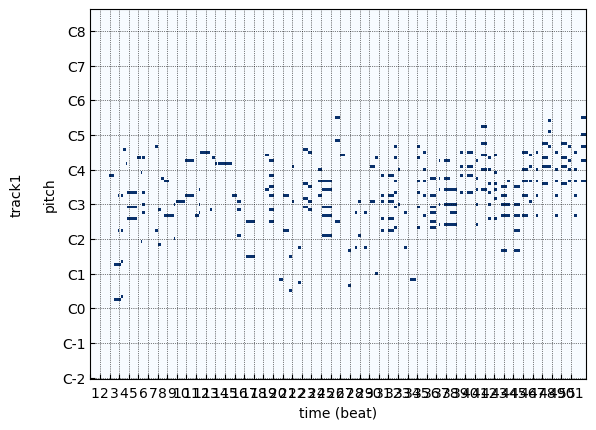

In [ ]:
sample_generator.generate(([],[]),sample_length=150,temperature=0.4)
sample_generator.gen2midi()

## Embedding LSTM with attention mechanism

In [ ]:
class EmbeddingRNNSequenceGenerator:
    def __init__(self, generator, seq_len = 32):
        self.pitches = generator.pitches
        self.durations = generator.durations
        self.pitch_encodings = generator.pitch_encodings
        self.pitch_vocab_size = generator.pitch_vocab_size
        self.duration_encodings = generator.duration_encodings
        self.duration_vocab_size = generator.duration_vocab_size
        self.seq_len = seq_len
        
    def generate_sequences(self, validation_split=0.15):
        
            
        pitch_inputs = []
        duration_inputs = []
        pitch_outputs = []
        duration_outputs = []

        for i in range(len(self.pitches)-self.seq_len):
            pitch_sequence_in = self.pitches[i:i + self.seq_len]
            duration_sequence_in = self.durations[i:i + self.seq_len]
            
            pitch_sequence_out = self.pitches[i + self.seq_len]
            duration_sequence_out = self.durations[i + self.seq_len]
            
            pitch_sequence_in = [self.pitch_encodings[char] for char in pitch_sequence_in]
            duration_sequence_in = [self.duration_encodings[char] for char in duration_sequence_in]
            
            pitch_sequence_out = self.pitch_encodings[pitch_sequence_out]
            duration_sequence_out = self.duration_encodings[duration_sequence_out]

            pitch_inputs.append(pitch_sequence_in)
            duration_inputs.append(duration_sequence_in)
            pitch_outputs.append(pitch_sequence_out)
            duration_outputs.append(duration_sequence_out)

        pitch_inputs = np.reshape(pitch_inputs, (len(pitch_inputs), self.seq_len))
        duration_inputs = np.reshape(duration_inputs, (len(duration_inputs), self.seq_len))
        inputs = [pitch_inputs, duration_inputs]
        
        pitch_outputs = to_categorical(pitch_outputs,self.pitch_vocab_size)
        duration_outputs = to_categorical(duration_outputs,self.duration_vocab_size)
        outputs = [pitch_outputs, duration_outputs]
        
        print(f'Input shape: {inputs[0].shape}')
        print(f'Output shape: {outputs[0].shape}')
        
        X_p_train, X_p_valid, X_d_train, X_d_valid, y_p_train, y_p_valid, y_d_train, y_d_valid = train_test_split(pitch_inputs, duration_inputs, pitch_outputs, duration_outputs, test_size=validation_split, random_state=RANDOM_SEED)
        
        return X_p_train, X_p_valid, X_d_train, X_d_valid, y_p_train, y_p_valid, y_d_train, y_d_valid

In [ ]:
class EmbeddingRNNAttention:
        
    def __init__(self, num_units, loss, lr, seq_len=32, embed_size=100):

        # create model architecture
        self.name = 'embedding_lstm_attention'
        
        if(not os.path.exists(os.path.join(BASE_PATH, 'weights',self.name))):
            os.mkdir(os.path.join(BASE_PATH, 'weights',self.name))
        
        self.weights_folder = os.path.join(BASE_PATH, 'weights',self.name)
        
        pitch_input = keras.layers.Input(shape=(seq_len,), name='pitch_input')
        duration_input = keras.layers.Input(shape=(seq_len), name='duration_input')

        x1 = keras.layers.Embedding(num_units[2], embed_size, name='pitch_embedding')(pitch_input)
        x2 = keras.layers.Embedding(num_units[3], embed_size, name='duration_embedding')(duration_input) 

        x = keras.layers.Concatenate()([x1,x2])

        x = keras.layers.LSTM(num_units[0], return_sequences=True)(x)
        #x = keras.layers.Dropout(0.2)(x)

        x = keras.layers.LSTM(num_units[1], return_sequences=True)(x)
        #c = keras.layers.Dropout(0.2)(x)

        # ATTENTION MECHANISM
        e = keras.layers.Dense(1, activation='tanh')(x)
        e = keras.layers.Reshape([-1])(e)
        alpha = keras.layers.Activation('softmax')(e)

        alpha_repeated = keras.layers.Permute([2,1])(keras.layers.RepeatVector(num_units[0])(alpha))

        c = keras.layers.Multiply()([x, alpha_repeated])
        c = keras.layers.Lambda(lambda xi: K.sum(xi,axis=1), output_shape=(num_units[0],))(c)

        pitch_output = keras.layers.Dense(num_units[2], activation='softmax', name='pitch')(c)
        duration_output = keras.layers.Dense(num_units[3], activation='softmax', name='duration')(c)

        model = keras.Model([pitch_input, duration_input], [pitch_output, duration_output], name=self.name)
        att_model = keras.Model([pitch_input, duration_input], alpha, name=f'{self.name}_model')
        
        # compile model
        optimizer = keras.optimizers.Adam(learning_rate=lr) # keras.optimizers.RMSprop(lr = lr)
        model.compile(loss=[loss,loss], optimizer=optimizer, metrics=['accuracy'])

        self.model = model
        self.att_model = att_model
        
        self.get_model_summary()
    
    def fit_model(self, train_inputs, train_outputs, validation_inputs, validation_outputs, store_path, epochs=100, batch_size=32):
        weights_folder = self.weights_folder
        
        checkpoint1 = ModelCheckpoint(
            os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        checkpoint2 = ModelCheckpoint(
            os.path.join(weights_folder, "weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        )

        early_stopping = EarlyStopping(
            monitor='loss'
            , restore_best_weights=True
            , patience = 10
        )


        callbacks_list = [
            checkpoint1
            , checkpoint2
            , early_stopping
         ]

        self.model.save_weights(os.path.join(weights_folder, "weights.h5"))
        history = self.model.fit(train_inputs, train_outputs
                  , epochs=epochs, batch_size=batch_size
                  , callbacks=callbacks_list
                  , validation_data=(validation_inputs, validation_outputs)
                  , shuffle=True
                 )
        
        self.model.save(os.path.join(weights_folder, "weights.h5"))
        
        return history
        
    def get_model_summary(self):
        self.model.summary()
        
    def plot_model_graph(self):
        return plot_model(self.model)
    
    def plot_loss(self, history):
        plt.figure()
        plt.plot(history.history['pitch_accuracy'])
        plt.plot(history.history['duration_accuracy'])
        plt.plot(history.history['val_pitch_accuracy'])
        plt.plot(history.history['val_duration_accuracy'])
        
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train (pitch)','Train (duration)', 'Validation (pitch)', 'Validation (duration)'])
        plt.show()

In [ ]:
class EmbeddingRNNSampleGenerator:
    def __init__(self, model, encoder, store_path=STORE_PATH):
        self.model = model.model
        self.encoder = encoder
        self.n_sample = 0
        self.store_path = store_path
        
    def generate(self, seed, sample_length, temperature=0.):
                
        note_stream, duration_stream = seed
        
        # create seed with start symbol
        notes_seed, durations_seed = seed
        
        notes_seed = [self.encoder.delimiter] * self.encoder.seq_len + notes_seed
        notes_seed = [self.encoder.pitch_encodings[symbol] for symbol in notes_seed]

        durations_seed = [0] * self.encoder.seq_len + durations_seed
        durations_seed = [self.encoder.duration_encodings[symbol] for symbol in durations_seed]
        
        
        for _ in range(sample_length):
            
            # limit seed to max_seq_len
            notes_seed = notes_seed[-self.encoder.seq_len:]
            durations_seed = durations_seed[-self.encoder.seq_len :]
            
            # add dimension for batch
            # (1, max_seq_len, vocab_size)
            # network_input = [np.reshape(notes_seed,(1,64)),np.reshape(durations_seed,(1,self.seq_len))]
            pitch_seed = np.reshape(notes_seed,(1,self.encoder.seq_len))
            duration_seed = np.reshape(durations_seed,(1,self.encoder.seq_len))
            network_input = [pitch_seed, duration_seed]
            
            
            # make a prediction
            note_prob_dist, duration_prob_dist = self.model.predict(network_input,verbose=0)
            # [0.1, 0.2, 0.1, 0.6] example -> softmax adds to 1
            
            note_output = self._sample_with_temperature(note_prob_dist[0], temperature)
            duration_output = self._sample_with_temperature(duration_prob_dist[0], temperature)
            
            # update seed
            notes_seed.append(note_output)
            durations_seed.append(duration_output)
            
            # map int to encoding
            note_symbol = [k for k, v in self.encoder.pitch_encodings.items() if v == note_output][0]
            duration_symbol = [k for k, v in self.encoder.duration_encodings.items() if v == duration_output][0]
            
            # check end of melody
            if (note_symbol == self.encoder.delimiter):
                break
            
            # update melody
            note_stream.append(note_symbol)
            duration_stream.append(duration_symbol)
            
        self.generated_sequence = (note_stream, duration_stream)
        self.n_sample=self.n_sample+1
        print(f'Generated sample n.{self.n_sample}')
    
    def gen2midi(self):

        filename = f'{DATASET}-{self.model.name}_n_{self.n_sample}.mid'

        notes, durations = self.generated_sequence
        extended_song = self.unpack(notes,durations)

        pianoroll = self.encoding2pianoroll(extended_song)

        bt = pr.BinaryTrack(name='track1', pianoroll=pianoroll)
        multitrack = pr.Multitrack(name='song1',tracks=[bt])
        
        self.plot_sample(multitrack)

        pr.write(f'{self.store_path}/{filename}', multitrack)
        print(f'Saved with name {filename}.')
        
    def unpack(self, notes, durations):
        timesteps = np.array([])
        for n,d in zip(notes,durations):
            timesteps = np.concatenate((timesteps, np.repeat(n,d)))
        return timesteps
    
    def encoding2pianoroll(self, extended_sample):
        ones_in = []
        pianoroll = np.zeros((extended_sample.shape[0],128),dtype='uint8')
        for i,n in enumerate(extended_sample):
            if(n==''):
                continue
            ones_in_ts = np.array([[i, int(n_i)] for n_i in n.split('.')])
            ones_in.append(ones_in_ts)
        ones_in = np.vstack(ones_in)
        rows = ones_in[:,0]
        cols = ones_in[:,1]
        pianoroll[rows,cols] = 1
        return pianoroll
    
    def plot_sample(self, midi):
        midi.plot()
    
    def _sample_with_temperature(self, distribution, temperature):
        # temperature -> inf then acts like random sampling
        # temperature -> 0 then the highest prob wins
        # temperature -> 1 
        # how explorative we want the network to be

        predictions = np.log(distribution) / temperature
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

        choices = range(len(distribution)) # [0, 1, 2 ,3]
        index = np.random.choice(choices, p=distribution) # sample from probability distribution
            
        return index

In [ ]:
SEQ_LEN = 32
NUM_UNITS = [256,256]
LOSS = 'categorical_crossentropy'
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 64

# Dataset encoder
denc = RNNDatasetEncoder(DATASET_PATH, seq_len=SEQ_LEN)
denc.encode()

# Dataset sequence generator
seq_generator = EmbeddingRNNSequenceGenerator(denc, seq_len=SEQ_LEN)
X_p_train, X_p_valid, X_d_train, X_d_valid, y_p_train, y_p_valid, y_d_train, y_d_valid = seq_generator.generate_sequences(validation_split=0.15)

X_train = [X_p_train, X_d_train]
X_valid = [X_p_valid, X_d_valid]
y_train = [y_p_train, y_d_train]
y_valid = [y_p_valid, y_d_valid]

# Compile model
units_per_layer = NUM_UNITS + [denc.pitch_vocab_size, denc.duration_vocab_size]
embedding_rnn_attention = EmbeddingRNNAttention(units_per_layer, LOSS, LR, seq_len=SEQ_LEN)


Processing song chpn_op10_e05
Processing song chpn_op10_e12
Processing song chpn_op10_e01
Processing song chpn_op7_1
Processing song chpn_op7_2
Processing song chp_op18
Processing song chpn_op23
Processing song chpn_op25_e2
Processing song chpn_op25_e3
Processing song chpn_op25_e4
Processing song chpn_op25_e11
Processing song chpn_op25_e12
Processing song chpn_op27_1
Processing song chpn_op27_2
Processing song chpn-p1
Processing song chpn-p2
Processing song chpn-p3
Processing song chpn-p4
Processing song chpn-p5
Processing song chpn-p6
Processing song chpn-p7
Processing song chpn-p8
Processing song chpn-p10
Processing song chpn-p11
Processing song chpn-p12
Processing song chpn-p13
Processing song chpn-p14
Processing song chpn-p15
Processing song chpn-p16
Processing song chpn-p17
Processing song chpn-p18
Processing song chpn-p19
Processing song chpn-p20
Processing song chpn-p21
Processing song chpn-p22
Processing song chpn-p23
Processing song chpn-p24
Processing song chp_op31
Processing

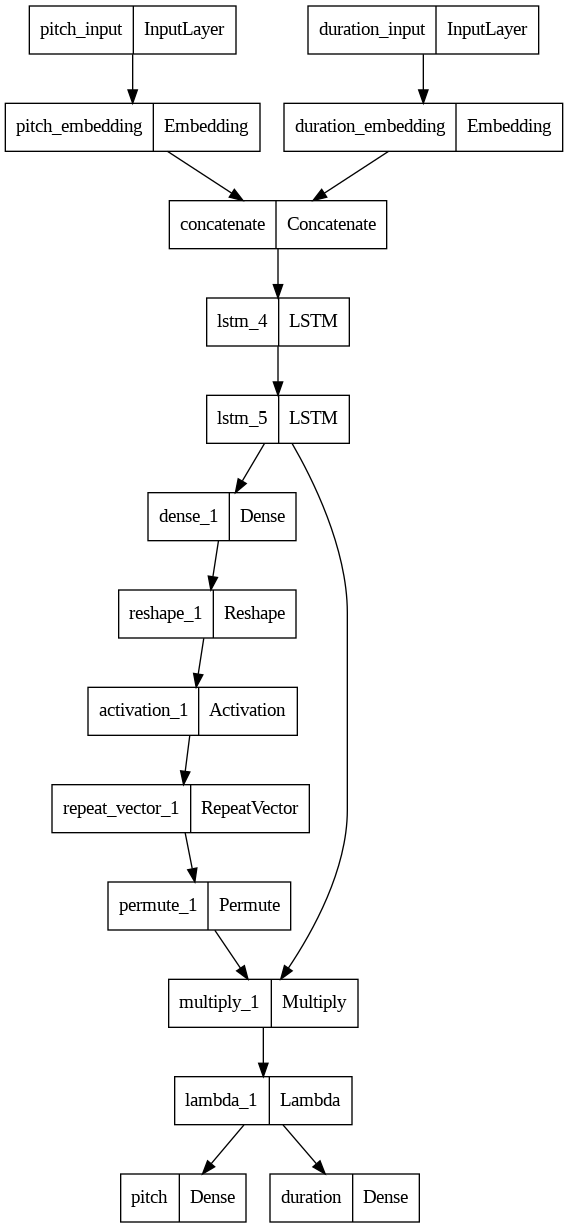

In [ ]:
embedding_rnn_attention.plot_model_graph()

In [ ]:
train_hist_att = embedding_rnn_attention.fit_model(X_train, y_train, X_valid, y_valid, STORE_PATH, epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/200
923/923 [==============================] - 79s 78ms/step - loss: 9.0730 - pitch_loss: 7.3066 - duration_loss: 1.7663 - pitch_accuracy: 0.1552 - duration_accuracy: 0.3937 - val_loss: 8.3145 - val_pitch_loss: 6.7707 - val_duration_loss: 1.5437 - val_pitch_accuracy: 0.1617 - val_duration_accuracy: 0.4094
Epoch 2/200
923/923 [==============================] - 27s 29ms/step - loss: 7.4808 - pitch_loss: 6.0161 - duration_loss: 1.4647 - pitch_accuracy: 0.1695 - duration_accuracy: 0.4342 - val_loss: 7.6670 - val_pitch_loss: 6.2106 - val_duration_loss: 1.4564 - val_pitch_accuracy: 0.1701 - val_duration_accuracy: 0.4304
Epoch 3/200
923/923 [==============================] - 21s 23ms/step - loss: 6.6074 - pitch_loss: 5.2266 - duration_loss: 1.3809 - pitch_accuracy: 0.1776 - duration_accuracy: 0.4600 - val_loss: 7.2905 - val_pitch_loss: 5.8696 - val_duration_loss: 1.4209 - val_pitch_accuracy: 0.1774 - val_duration_accuracy: 0.4504
Epoch 4/200
923/923 [==============================] - 

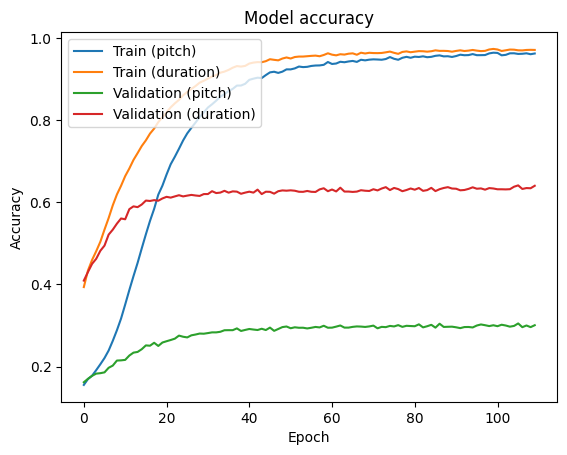

In [ ]:
embedding_rnn_attention.plot_loss(train_hist_att)

In [ ]:
sample_generator = EmbeddingRNNSampleGenerator(embedding_rnn_attention, encoder=denc)

Generated sample n.1
Saved with name chopin-embedding_lstm_attention_n_1.mid.


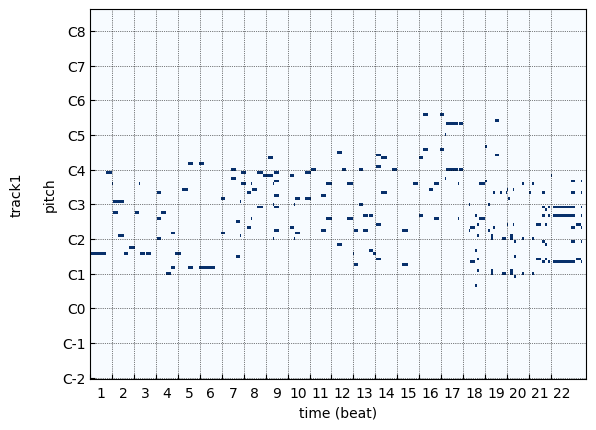

In [ ]:
sample_generator.generate(([],[]),sample_length=150,temperature=0.4)
sample_generator.gen2midi()